# 自己組織化マップ (Self-Organizing Map; SOM)

![](simply_som.gif)

In [1]:
# 必要なパッケージをimport
from tqdm.auto import tqdm,trange
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_fontja

::::{admonition} matplotlibで日本語を使うための準備  
:class: tip, dropdown

```python
# Python 3.12以降
try:
    import matplotlib-fontja
except:
    !pip install matplotlib-fontja
    import matplotlib_fontja

# Python 3.11以前
try:
    import japanize_matplotlib
except:
    !pip install japanize_matplotlib
    import japanize_matplotlib
```

::::

## 近傍関数を簡単のためにシンプルにしたバージョン

### 実験設定

__ハイパーパラメータ__ を定義。

:::{margin}
※ハイパーパラメータとは
* 機械学習モデルを訓練させる前に定義する定数のこと。
* 訓練（学習ともいう）の際に使用する値であり、通常は訓練によって値が変わることはない。  

:::

In [2]:
# 潜在空間の範囲を指定（変数名はもっといい名付け方があると思います...）
n_xaxis = 30
n_yaxis = 30

# 潜在空間上のグリッドにはそれぞれ、ニューロンが配置されます。このニューロンが持っている参照ベクトルの次元数を定義。入力データの特徴数と同じ値です。
n_channels = 3

# 最大学習回数
max_iter = 100

# 学習率。αやlr（leraning_rate）と言われることが多いです。
alpha = 0.08

__学習可能パラメータ__ を準備。

:::{margin}
※学習可能パラメータとは
* 機械学習モデルを訓練させるときに、訓練に従って値が書き変わっていくパラメータのこと。  
:::

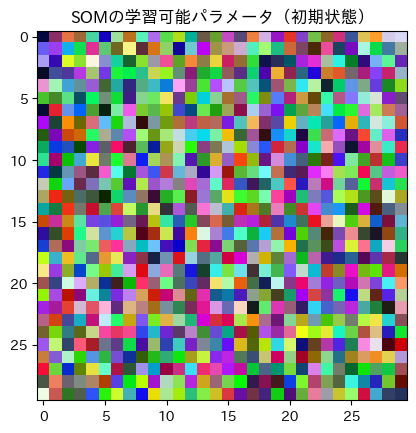

In [3]:
# 二次元の配列のそれぞれの要素がベクトルであるイメージ。つまり実際には三次元配列になる。
weight = np.random.random([n_xaxis,n_yaxis,n_channels])

# 定義した学習可能パラメータをheatmapとして可視化してみよう。
plt.title("SOMの学習可能パラメータ（初期状態）")
plt.imshow(weight)
plt.show()

### 学習に用いるサンプルデータを準備

デモンストレーションを行うために、訓練に用いるサンプルデータを作ります。ここでは、RGBの特徴を持ったベクトルを100個作りましょう。

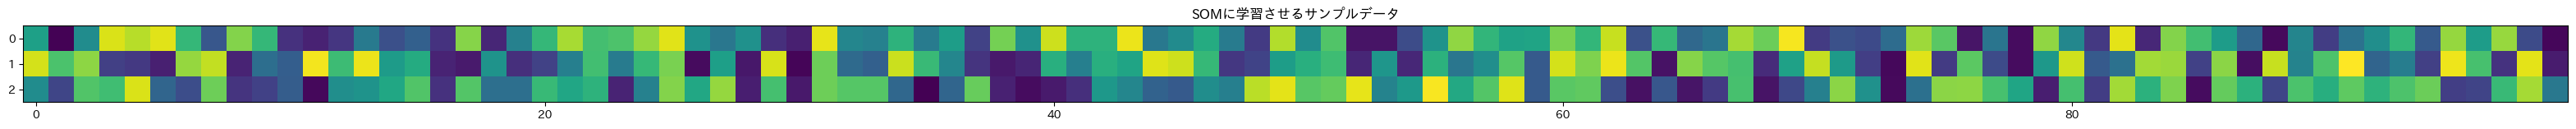

In [4]:
demo_data = np.random.random([100, 3])

plt.figure(figsize=(40,400))
plt.title("SOMに学習させるサンプルデータ")
plt.imshow(demo_data.T)
plt.show()

### 訓練stepの作成

訓練データを一つ一つ受け取り、パラメータを更新する関数を作成する。

In [5]:
def som(color_vec, weight):
    """Self-Organizing Mapの学習可能パラメータ（weight）の更新を行う関数。
    データを一つ一つ受け取り、最も類似度の高いニューロンとその周辺（前後左右各2マス分）のパラメータを更新する。
    ただし、簡単のために近傍関数はステップ関数にしている。
    """
    # 入力データ（color_vec）と最も近い座標を特定する。
    min_index = np.argmin(((weight - color_vec)**2).sum(axis=2))

    # ただし、二次元座標が欲しいので変換する。
    _, n_yaxis, _ = weight.shape
    mini = int(min_index / n_yaxis)
    minj = int(min_index % n_yaxis)

    # 選ばれたニューロンの近傍（前後左右2マス）の重みを更新する。
    for i in range(-2,3): # -2, -1, 0, 1, 2
        for j in range(-2,3): # -2, -1, 0, 1, 2
            try:
                weight[mini+i,minj+j] += alpha * (color_vec - weight[mini+i,minj+j])
            except:
                pass
    return weight


### 訓練ループの作成と実行

訓練が長時間になる可能性があるので、ここではtrangeを使う。これはプログレスバーの表示とrange関数の機能を両方持った関数。


  0%|          | 0/100 [00:00<?, ?it/s]

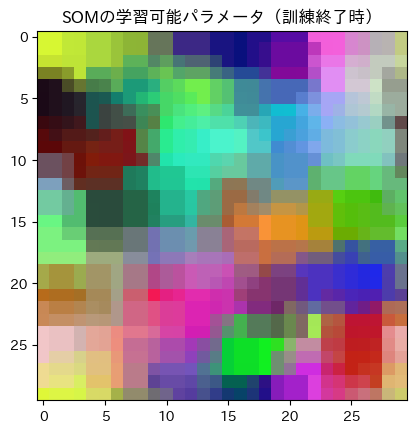

In [6]:
for time in trange(max_iter):
    for color_vec in demo_data:
        weight = som(color_vec, weight)

plt.title("SOMの学習可能パラメータ（訓練終了時）")
plt.imshow(weight,interpolation='none')
plt.show()

## 課題(1)

デモデータをSOMで訓練して作成した潜在空間を画像として保存し、moodleの（課題3）に提出せよ。

## 課題(2)

近傍関数を以下の要請に従うように作成せよ。

1. argumentsとして「入力データと最も近いニューロンのindex」と「潜在空間のshape」を受け取る
1. そのニューロンと全てのニューロンとの距離を計算する
1. 距離行列を0~1に収まるように正規化する
1. 類似度行列=1- 距離行列
1. 類似度行列をreturnする

これをもとに上記のsomプログラムを修正せよ。（パラメータ更新の際に、全てのニューロンに対する近傍関数の値と更新値との要素積を取ればいいはず）

最後に、作成した潜在空間を画像として表示せよ。

### ヒント

ヒント1 :

以下のように実装できるはず。（get_axis_matrixと正規化関数を作成する必要がある）

```python
def neighborhood(best_index, latent_shape):
    潜在空間での座標 = get_axis_matrix(*latent_shape) # 例として(5,5)
    距離 = np.sum((潜在空間での座標 - best_index)**2, axis=2) # 引き算して
    正規化した距離 = 正規化（距離）
    類似度 = 1- 正規化した距離
    return 類似度
```

ヒント2:

正規化は
```python
(距離-距離.min()) / (距離.max() - 距離.min())
```
で実装できる



ヒント3:

get_axis_matrixを以下に示す。

In [10]:
def get_axis_matrix(x_length, y_length):
    """
    潜在空間のshapeを渡すと、各ニューロンの座標を入れた三次元配列を返す
    """
    axis_matrix = []
    for i in range(x_length):
        axis_matrix.append([])
        for j in range(y_length):
            axis_matrix[-1].append([i,j])
    return np.array(axis_matrix)

ヒント4:

近傍関数を以下に示す。

In [11]:
def neighborhood(best_index, latent_shape):
    潜在空間での座標 = get_axis_matrix(*latent_shape) # 例として5,5
    距離 = np.sum((潜在空間での座標 - best_index)**2, axis=2) # 引き算して
    正規化した距離 = (距離-距離.min()) / (距離.max() - 距離.min())
    類似度 = 1- 正規化した距離
    return 類似度

print(neighborhood([1,2], [5,5]).shape)
neighborhood([1,2], [5,5])

(5, 5)


array([[0.61538462, 0.84615385, 0.92307692, 0.84615385, 0.61538462],
       [0.69230769, 0.92307692, 1.        , 0.92307692, 0.69230769],
       [0.61538462, 0.84615385, 0.92307692, 0.84615385, 0.61538462],
       [0.38461538, 0.61538462, 0.69230769, 0.61538462, 0.38461538],
       [0.        , 0.23076923, 0.30769231, 0.23076923, 0.        ]])